Extract transect across image <br>
Make this into a python function at some point

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic
%matplotlib  widget

In [2]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
cropdir='cropped_9000_1800_18000_3600/'

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
#print(str(len(dates))+' dates so far!')
nd=len(dates)

In [3]:
# load single igram
date1='20190112'
date2='20190124'

x0=0; dx=18000; y0=0; dy=3600 # changes with different subregion
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
int12 = slc1 * np.conj(slc2)

<br>Right now, startx must be smaller than endx and starty must be smaller than endy. <br>
This is a problem that I need to fix and I am not sure how yet. <br> <br>

In [4]:
# define the points you want the transect to be between
startx=12000; starty=0
endx=9234; endy=1345

# trying shallower angle for testing 
startx=9234; starty=1345
endx=12000; endy=2000

In [5]:
print(np.shape(int12)) # full igram dimensions 

(3600, 18000)


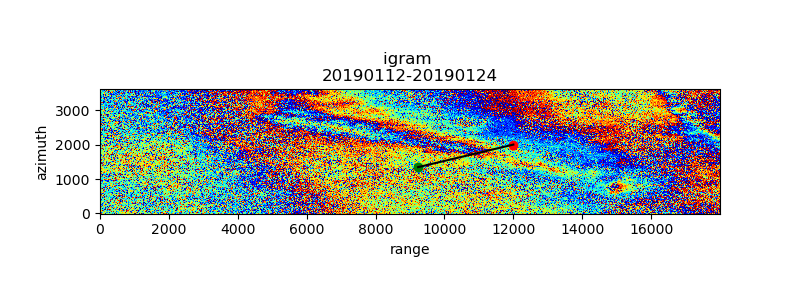

In [6]:
# now plot it spatially 
plt.figure(figsize=(8,3))
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
           interpolation='nearest', origin='lower')
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("igram \n"+str(date1)+"-"+str(date2))
#plt.colorbar()
#plt.xlim(dx, 0)
plt.plot(startx,starty,'go')
plt.plot(endx,endy,'ro')
line1=([startx,endx],[starty,endy])
plt.plot(line1[0],line1[1],'k-')
plt.show()

In [7]:
# Calculate the angle that we need to rotate the points (from the right/horizontal)
theta = np.arctan((endy-starty)/(endx-startx))
#theta = theta*180/np.pi # converting to degrees
print(theta)
print(str(theta*180/np.pi)+' degrees')

0.2325209067428092
13.322466604917972 degrees


In [8]:
# design the rotation matrix
rot = np.zeros((2,2),'float')
rot[0] = [np.cos(theta),np.sin(theta)]
rot[1] = [-np.sin(theta),np.cos(theta)]
print(rot)

[[ 0.97308859  0.23043132]
 [-0.23043132  0.97308859]]


In [9]:
print('extracted box range length: '+str(endx-startx)+' (width)')
print('extracted box azimuth length: '+str(endy-starty)+' (height)')

extracted box range length: 2766 (width)
extracted box azimuth length: 655 (height)


In [10]:
# make sure that the x and y distances of the smaller box are positive
dx = int(np.abs(endx-startx))
dy = int(np.abs(endy-starty))
print('extracted box range length: '+str(dx)+' (width)')
print('extracted box azimuth length: '+str(dy)+' (height)')

if startx > endx:
    lowx = endx
elif startx < endx:
    lowx = startx
if starty > endy:
    lowy = endy
elif starty < endy: 
    lowy = starty

extracted box range length: 2766 (width)
extracted box azimuth length: 655 (height)


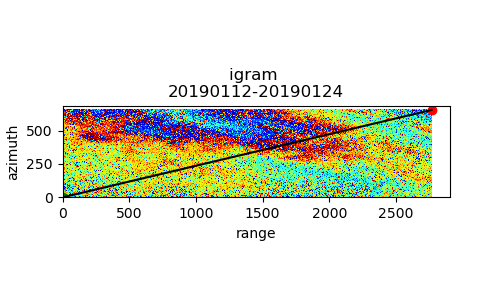

In [11]:
# Extract the data in the box that includes the transect 
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1crop = ds.GetRasterBand(1).ReadAsArray(startx,starty,endx-startx,endy-starty)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2crop = ds.GetRasterBand(1).ReadAsArray(startx,starty,endx-startx,endy-starty)
int12crop = slc1crop * np.conj(slc2crop)

plt.figure(figsize=(5, 3))
plt.imshow(np.angle(int12crop),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
           interpolation='nearest',origin='lower')
plt.ylabel('azimuth'); plt.xlabel('range')
plt.title("igram \n"+str(date1)+"-"+str(date2))
#plt.colorbar()
plt.plot(0,0,'go')
plt.plot(endx-startx,endy-starty,'ro')
line2=([0,endx-startx],[0,endy-starty])
plt.plot(line2[0],line2[1],'k-')
# Zoomed in 
#plt.xlim([endx-startx,0])
#plt.ylim([0,endy-starty])
plt.show()

In [31]:
# make line2 the right format for being rotated and plotted in new coord system
line2 = np.zeros((2,2),'float')
line2[0] = [0,endx-startx] # x
line2[1] = [0,endy-starty] # y
print(line2)

[[   0. 2766.]
 [   0.  655.]]


In [13]:
# make a meshgrid for defining coordinates of the centers of pixels 
x = np.arange(0,endx-startx,1)
y = np.arange(0,endy-starty,1)
grdx,grdy = np.meshgrid(x,y,indexing='xy')

print(endx-startx)
#print(endy-starty)
print(x[0:10])
print(x[-10:-1])
print(np.shape(grdy))
#print(grd[1])
#print(255*766)
print(type(grdx))
ny,nx = np.shape(grdx)
print('nx: '+str(nx))
print('ny: '+str(ny))
grdx1 = grdx.reshape(1,nx*ny) # NOT RIGHT? do we really use nx and ny here? 
grdy1 = grdy.reshape(1,nx*ny)
grd = np.vstack((grdx1,grdy1))  
print(np.shape(grd))

2766
[0 1 2 3 4 5 6 7 8 9]
[2756 2757 2758 2759 2760 2761 2762 2763 2764]
(655, 2766)
<class 'numpy.ndarray'>
nx: 2766
ny: 655
(2, 1811730)


In [14]:
print(np.max(grdy1))

654


In [15]:
# New (startx,starty) (endx, endy) points are moved over
startx1 = 0; starty1 = 0; endx1 = endx-startx; endy1 = endy-starty

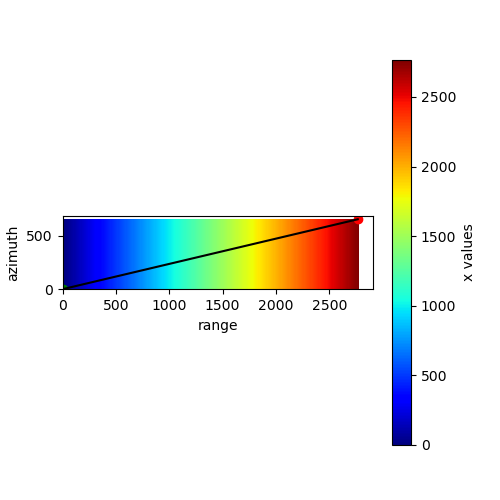

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(grdx, cmap='jet', aspect='equal', \
           interpolation='nearest',origin='lower')
plt.ylabel('azimuth'); plt.xlabel('range')
plt.plot(0,0,'go')
plt.plot(endx-startx,endy-starty,'ro')
line1=([0,endx-startx],[0,endy-starty])
plt.plot(line1[0],line1[1],'k-')
cbar=plt.colorbar()
cbar.set_label('x values')
#cbar.set_label('y values')
plt.show()

In [17]:
newxy = np.matmul(rot,grd)
print(np.shape(newxy))

#reshape again
y1 = newxy[1,:].reshape((ny,nx)) # this is distance along transect
x1 = newxy[0,:].reshape((ny,nx)) # this is distance perpendicular to transect

(2, 1811730)


In [18]:
print('new Xs: '+str(np.shape(x1)))
print('new Ys: '+str(np.shape(y1)))

print(np.max(x1))

new Xs: (655, 2766)
new Ys: (655, 2766)
2841.2920385733278


In [19]:
# rotate the points on the line also 
lineRot = np.matmul(rot,line2)
print(lineRot)

[[ 0.00000000e+00  2.84249556e+03]
 [ 0.00000000e+00 -2.22044605e-15]]


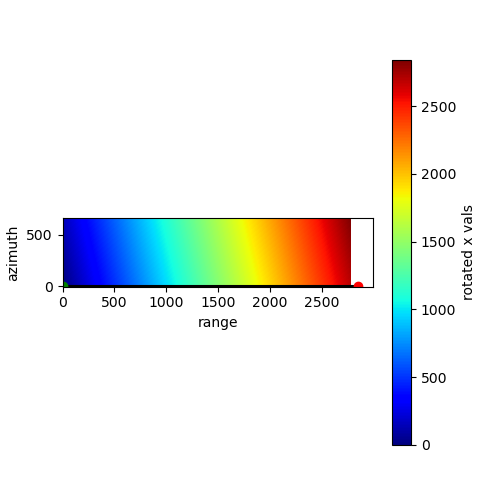

In [20]:
# plot distances off transect 
plt.figure(figsize=(5, 5))
plt.imshow(x1, cmap='jet', aspect='equal',origin='lower')
plt.ylabel('azimuth'); plt.xlabel('range')
plt.plot(lineRot[0],lineRot[1],'k-')
plt.plot(lineRot[0][0],lineRot[1][0],'go')
plt.plot(lineRot[0][1],lineRot[1][1],'ro')
cbar = plt.colorbar()
cbar.set_label('rotated x vals')
plt.show()

In [21]:
# how far off of the transect do you want to select pixels for? 
perpDist = 5
# this will average over 10 pixels off transect in BOTH directions (perpendicular) 

# gives the indices where the 
ind = np.where(np.abs(y1) < perpDist)
print(np.shape(ind))
print(ind)

(2, 28313)
(array([  0,   0,   0, ..., 654, 654, 654]), array([   0,    1,    2, ..., 2763, 2764, 2765]))


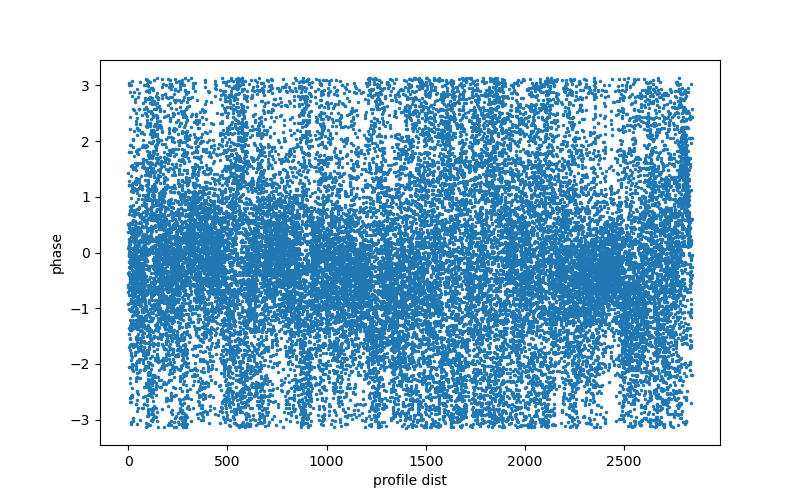

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(x1[ind],np.angle(int12[ind]),'.',markersize=3)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()

In [23]:
print(nx)
print(np.max(x1))
# WHY ARE THESE DIFFERENT? 

tsctLength = np.sqrt(np.square(endx-startx)+np.square(endy-starty))
print(tsctLength)

2766
2841.2920385733278
2842.495558483777


In [24]:
# now bin the values 
bins = np.arange(0,np.max(x1),10)
#print(bins)

dists = x1[ind]
vals = int12[ind] 

#print(dists)
#print(vals)

binnedVals=np.ndarray([len(bins),1],'complex')

for i in np.arange(len(bins)-1):
    #print('i: '+str(i))
    #print('bin start: '+str(bins[i]))
    #print('bin end: '+str(bins[i+1]))
    inds = (np.where((dists >= bins[i]) & (dists < bins[i+1])))
    #print(inds)
    binnedVals[i]= np.mean(vals[inds])
    #print(binnedVals[i])

#print(bins[-10:-1])
#print(bin_means[0:10])
#print(np.shape(bins))
#print(np.shape(bin_means))

In [25]:
print(np.shape(bins))
print(np.shape(binnedVals))
print(type(binnedVals[0,0]))

(285,)
(285, 1)
<class 'numpy.complex128'>


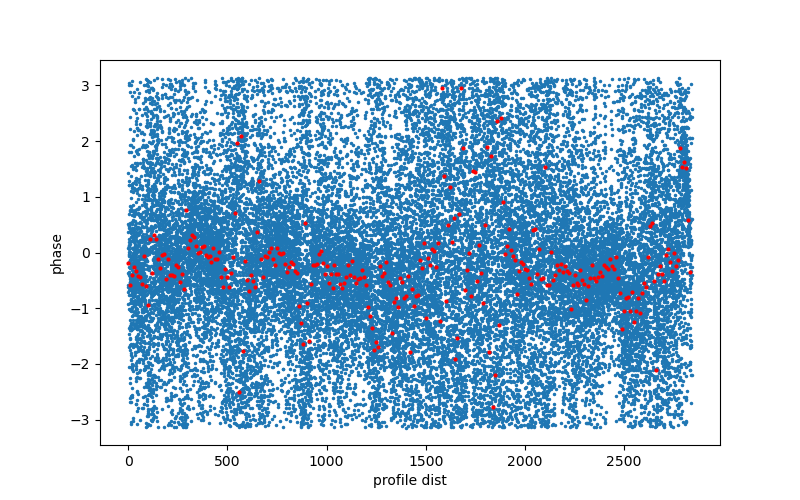

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(x1[ind],np.angle(int12[ind]),'.',markersize=3)
plt.plot(bins,np.angle(binnedVals),'r.',markersize=4)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()

In [27]:
# print the first ~10 values of the results to compare to output of function
# to make sure it's working properly 
print('bins 1-10: '+str(bins[0:10]))
print('binnedVals 1-10: \n'+str(np.angle(binnedVals[0:10])))

bins 1-10: [ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]
binnedVals 1-10: 
[[-0.18964112]
 [-0.57977539]
 [-0.41014237]
 [-0.26115122]
 [-0.32769175]
 [-0.42516738]
 [-0.44550025]
 [-0.56159116]
 [-0.06851083]
 [-0.59241484]]


In [28]:
# simple unwrapping algorithm 
phs = np.angle(binnedVals)
unwrapped = np.ndarray(len(phs),'float')

# start a counter 
count = 0;
for i in np.arange(len(phs)-1):
    unwrapped[i] = phs[i]+count
    jump = (phs[i+1]-phs[i])
    if (np.abs(jump) > np.pi): 
        if (jump > 0):
            count -= 2*np.pi
        else:
            count += 2*np.pi

/tmp/ipykernel_150479/3604477945.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  unwrapped[i] = phs[i]+count


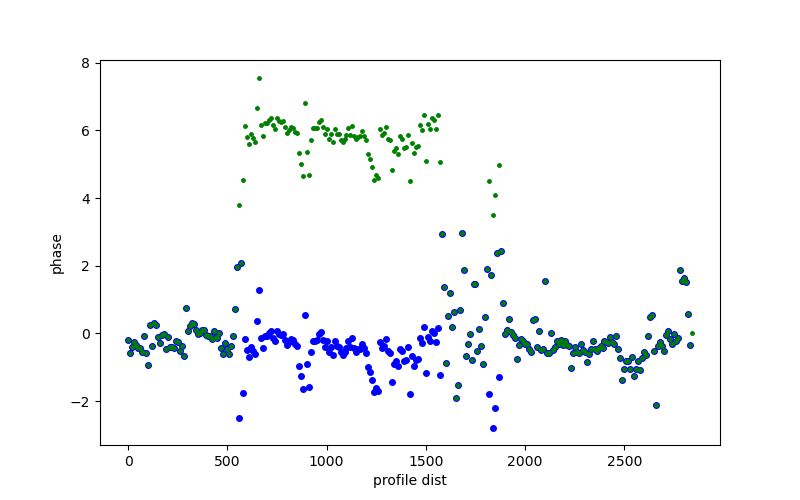

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(bins,phs,'b.',markersize=8)
plt.plot(bins,unwrapped,'g.',markersize=5)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()

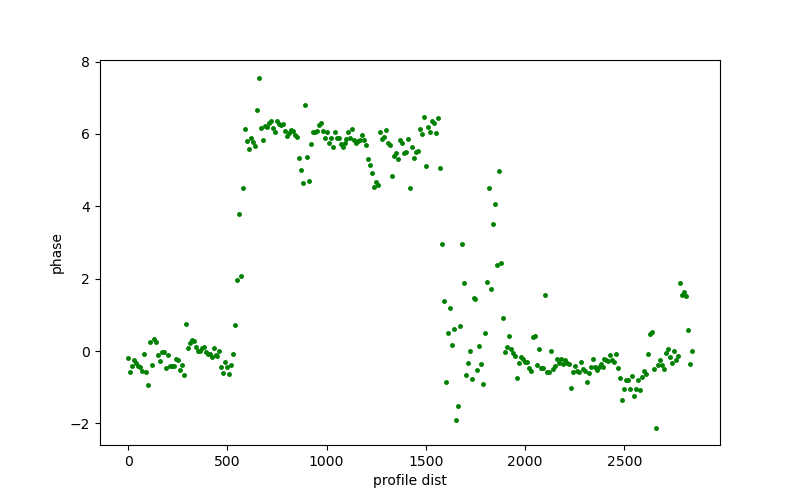

In [30]:
plt.figure(figsize=(8, 5))
#plt.plot(bins,phs,'b.',markersize=8)
plt.plot(bins,unwrapped,'g.',markersize=5)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()